# Narrow-band high frequency signals

Ignores any stationary contribution


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate as integrate
from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts

print_figs = True

---

## High frequency signal

In [2]:
models = ['exponential', 'gaussian']
U = {m: hf.high_frequency_signal(model=m) for m in models}

In [3]:
for m, u in U.items():
    print(m+":")
    display(u.autocorrelation)

exponential:


U**2*exp(-tau/T)*cos(sigma*tau)/2

gaussian:


U**2*exp(-tau**2/T**2)*cos(sigma*tau)/2

In [4]:
for m, u in U.items():
    print(m+":")
    display(u.spectrum)

exponential:


T*U**2*(T**2*(omega**2 + sigma**2) + 1)/(T**4*(-omega**2 + sigma**2)**2 + 2*T**2*(omega**2 + sigma**2) + 1)

gaussian:


sqrt(pi)*T*U**2*(exp(-T**2*(omega + sigma)**2/4) + exp(-T**2*(-omega + sigma)**2/4))/4

### check Parseval

In [5]:
# check Parseval: !!! 2 pi factor required
from sympy import oo, pi

for m, u in U.items():
    _E = u.spectrum.subs({u.p["sigma"]: 2/u.p["T"]}) # hack, required (atan issues with sympy)
    _I = _E.integrate((u.omega, 0, oo)) *2 /2/pi
    #_I = _E.integrate((u.omega, -oo, oo)) /2/pi # not working for exp
    print(m+":")
    display(_I.simplify())

exponential:


U**2/2

gaussian:


U**2/2

### value at frequency 0

In [6]:
# value at 0 frequency
for m, u in U.items():
    _E0 = u.spectrum.subs({u.omega:0})
    print(m+":")
    display(_E0.simplify())

exponential:


T*U**2/(T**2*sigma**2 + 1)

gaussian:


sqrt(pi)*T*U**2*exp(-T**2*sigma**2/4)/2

### plots

Text(0.5, 1.0, 'non-stationary time scale T= 10.0d')

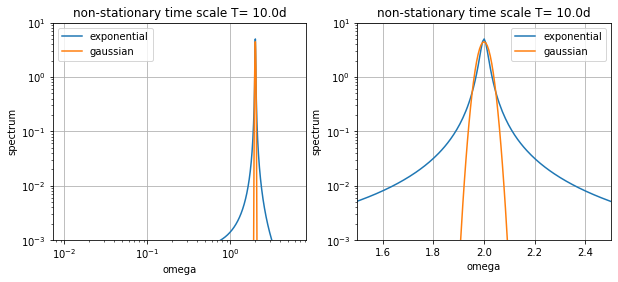

In [7]:
# for multiple parameter values:
T = 10.

fig, axes = plt.subplots(1,2,figsize=(10,4))

ax = axes[0]
for m, u in U.items():
    E = u.evaluate_spectrum(T=T, omega=dict(N=1000))
    E.plot(ax=ax, label=m)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e1)
ax.legend()
ax.grid()
ax.set_title('non-stationary time scale T= {}d'.format(T))

ax = axes[1]
for m, u in U.items():
    E = u.evaluate_spectrum(T=T, omega=dict(N=1000))
    E.plot(ax=ax, label=m)
    
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1.5, 2.5)
ax.set_ylim(1e-3, 1e1)
ax.legend()
ax.grid()
ax.set_title('non-stationary time scale T= {}d'.format(T))


### nondimensional expression

In [8]:
for m, u in U.items():
    omega, T, sigma = u.omega, u.p['T'], u.p['sigma']
    s = Symbol('s', positive=True)
    o = Symbol('o', positive=True)
    u_norm = u.spectrum.subs({sigma:s/T, omega:o/T}) #.subs({sigma: 1})
    #u_lbd = lambdify([o, Us, t, sigma], u)
    display(u_norm.simplify())

T*U**2*(o**2 + s**2 + 1)/(2*o**2 + 2*s**2 + (o**2 - s**2)**2 + 1)

sqrt(pi)*T*U**2*(exp(o*s) + 1)*exp(-o**2/4 - o*s/2 - s**2/4)/4

## integrate spectrum around central frequency

In [9]:
delta = np.linspace(0, 2., 30)[1:] # nondim by 1/T
sigma = np.linspace(0., 2., 30)[1:] # nondim by 1/T
ds = xr.Dataset(None, coords={'delta': (['delta'], delta),
                              'sigma': (['sigma'], sigma)},)

In [10]:
delta, sigma = xr.broadcast(ds.delta, ds.sigma)
T = u.p_values['T']

I = {}
for m, u in U.items():
    u_lbd = lambdify([u.omega, u.p['U'], u.p['T'], u.p['sigma']], u.spectrum)
    #fun = lambda omega, sigma: max(1e-5, u_lbd(omega, u.p_values['U'], u.p_values['T'], sigma))
    fun = lambda omega, sigma: u_lbd(omega, u.p_values['U'], T, sigma)
    Ifun = lambda d, s: integrate.quad(fun, max(0.,s-d), s+d, args=(s,), points=(s,))[0] *2 /2/np.pi
    #
    ufunc = np.vectorize(Ifun)
    da = xr.DataArray(ufunc(2*np.pi*delta/T, 2*np.pi*sigma/T), dims=("delta", "sigma")).assign_coords(**ds.coords)
    #da = da.where(da.delta<da.sigma)
    I[m] = da

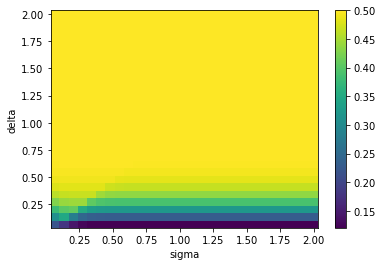

In [11]:
I["gaussian"].plot()

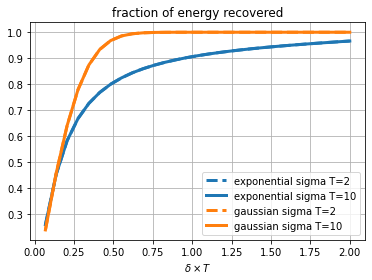

In [12]:
colors = {m: c for m, c in zip(models, ['tab:blue','tab:orange'])}

ax = plt.subplot(111)

variance = 0.5*u.p_values['U']

for m, da in I.items():
    toplt = da.sel(sigma=2., method='nearest')/variance
    toplt.plot(color=colors[m], lw=3, ls='--',
               ax=ax, label=m+' sigma T=2')
    #
    da = da.assign_coords(delta_over_sigma=da.delta/10.)
    toplt = da.sel(sigma=10., method='nearest')/variance
    toplt.plot(color=colors[m], lw=3, ax=ax, label=m+' sigma T=10')

ax.legend()
ax.set_title("fraction of energy recovered")
ax.set_xlabel(r"$\delta \times T$")

ax.grid()


**Conclusion:** 

90% of the total variance is recovered if the filter bandwidth is (approximately):

- $1/T$ for exponential autocorrelations
- $1/3T$ for gaussian shapes
